1. Предобрадотка данных

In [189]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/Mykes/rus_med_dialogues_qa/" + splits["train"])

In [190]:
df.head()

,topic,user_question,assistant_answer,to_doctor,__index_level_0__,prompt
0,лабораторные исследования,Я сдала анализ крови на сахар и показатели чут...,Повышение уровня сахара в крови может быть выз...,эндокринолог,3263,<s><|user|>Я сдала анализ крови на сахар и пок...
1,педиатрия,"Мой ребенок кашляет уже 3 дня, отхаркивается с...",Кашель у детей может быть вызван разными причи...,педиатр,518,"<s><|user|>Мой ребенок кашляет уже 3 дня, отха..."
2,проктология,Я заметил не очень приятного вида опухоль возл...,"Извините, я не могу ставить диагнозы. Анальные...",проктолог,1160,<s><|user|>Я заметил не очень приятного вида о...
3,эндокринология,У меня повышенный уровень сахара в крови. Врач...,Повышенный уровень сахара в крови - это действ...,эндокринолог,286,<s><|user|>У меня повышенный уровень сахара в ...
4,семейная медицина,У меня постоянно болит голова. Я уже несколько...,Головные боли могут быть вызваны множеством пр...,невролог,2132,<s><|user|>У меня постоянно болит голова. Я уж...


In [191]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
from gensim.models import Word2Vec
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [192]:
#Приведите тексты к единому формату: удалите спецсимволы, числа и приведите буквы к нижнему регистру.

#Функция для пртведения текста к одному формату
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Удаляем спецсимволы
    text = re.sub(r'\d+', '', text)     # Удаляем числа
    return text.lower()                 # Приводим к нижнему регистру

In [193]:
df['user_question_cleaned'] = df['user_question'].apply(preprocess_text)
df['assistant_answer_cleaned'] = df['assistant_answer'].apply(preprocess_text)


In [194]:
df.to_doctor.value_counts()

,count
to_doctor,
эндокринолог,269
терапевт,255
кардиолог,243
гинеколог,237
дерматолог,236
...,...
терпевт,1
онколог-нейрохирург,1
урология,1


In [195]:
#Столбец to_doctor является нашим target потому что в нём содержатся специальности врачей, к которым направили пациентов

In [196]:
#Видим большое количество специалистов, этот список нужно сократить как можно сильнее для более эфективного предсказания

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103]),
 [Text(0, 0, 'эндокринолог'),
  Text(0, 1, 'терапевт'),
  Text(0, 2, 'кардиолог'),
  Text(0, 3, 'гинеколог'),
  Text(0, 4, 'дерматолог'),
  Text(0, 5, 'невролог'),
  Text(0, 6, 'проктолог'),
  Text(0, 7, 'травматолог'),
  Text(0, 8, 'уролог'),
  Text(0, 9, 'стоматолог'),
  Text(0, 10, 'психиатр'),
  Text(0, 11, 'аллерголог'),
  Text(0, 12, 'педиатр'),
  Text(0, 13, 'офтальмолог'),
  Text(0, 14, 'хирург'),
  Tex

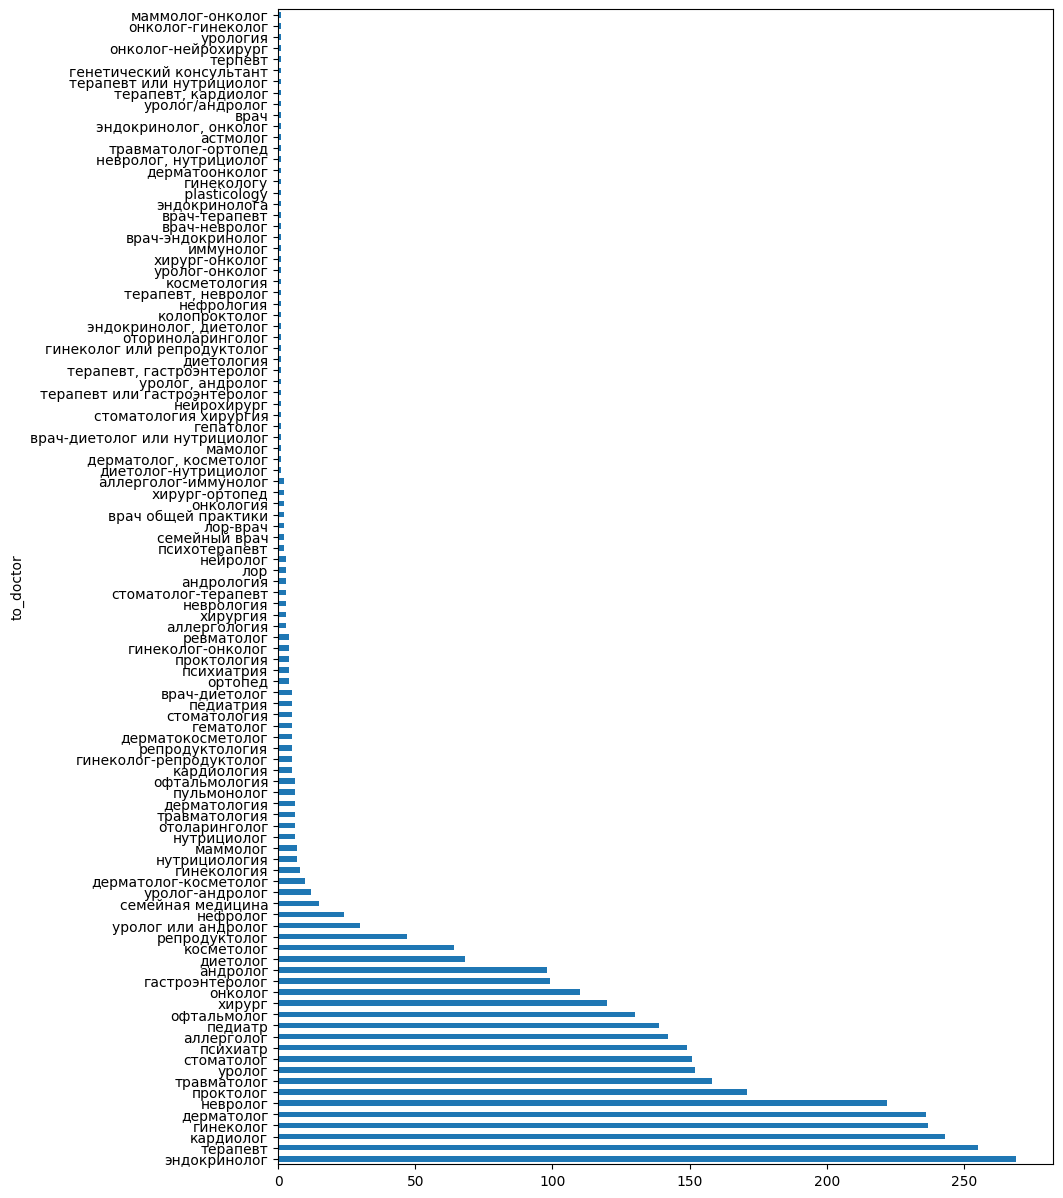

In [197]:
plt.figure(figsize=(10, 15))
df['to_doctor'].value_counts().plot(kind='barh')
plt.xticks(fontsize=10)  # Уменьшаем размер шрифта по оси X
plt.yticks(fontsize=10)  # Уменьшаем размер шрифта по оси Y

In [198]:
#Во-первых, мы должны убрать пробелы после названия специалистов; оставить только 1 спеицальность в названии(убрав 'или')
def clean_name(name):
    name = name.strip().lower()
    name = name.replace(' ', '').replace('-', '')
    name = re.sub(r'или.*', '', name)  # Убираем текст после 'или'
    return name

#Используем функцию
df['to_doctor'] = df['to_doctor'].str.strip().str.lower()
df['to_doctor_cleaned'] = df['to_doctor'].apply(clean_name)

In [199]:
#Видим что одни и теже врачи повторяются(из-за разной записи, например терапевт - терпевт), исправляем это:

#Создаём словарь для замены названия специальностей
normalization_dict = {
    'терапевт': ['терапевт', 'врач общей практики', 'врач-терапевт', 'терпевт'],
    'гинеколог': [
        'гинеколог', 'гинеколог/репродуктолог', 'репродуктолог', 'гинекологу',
        'гинекология', 'гинеколог-репродуктолог', 'репродуктология',
        'гинеколог-онколог', 'онколог-гинеколог', 'гинеколог или репродуктолог'
    ],
    'кардиолог': ['кардиолог', 'врач-кардиолог', 'кардиология', 'терапевт, кардиолог'],
    'дерматолог': [
        'дерматолог', 'дерматолог-косметолог', 'дерматология', 'врач-дерматолог',
        'дерматокосметолог', 'дерматоонколог', 'дерматолог, косметолог'
    ],
    'стоматолог': [
        'стоматолог', 'стоматология хирургия', 'врач-стоматолог', 'стоматология',
        'стоматолог-терапевт'
    ],
    'эндокринолог': [
        'эндокринолог', 'врач-эндокринолог', 'эндокринолога', 'эндокринолог, онколог',
        'эндокринолог, диетолог'
    ],
    'невролог': [
        'невролог', 'врач-невролог', 'невропатолог', 'нейролог',
        'терапевт, невролог', 'невролог, нутрициолог', 'неврология'
    ],
    'уролог': [
        'уролог', 'уролог или андролог', 'уролог/андролог', 'уролог-андролог',
        'врач-уролог', 'уролог, андролог', 'урология', 'уролог-онколог'
    ],
    'педиатр': ['педиатр', 'педиатрия'],
    'онколог': [
        'онколог', 'онколог-гинеколог', 'онкология', 'терапевт, онколог',
        'онколог-нейрохирург', 'хирург-онколог', 'маммолог-онколог'
    ],
    'андролог': ['андролог', 'уролог/андролог', 'андрология'],
    'хирург': [
        'хирург', 'хирургия', 'хирург-ортопед', 'травматолог-ортопед',
        'хирург-онколог', 'травматолог'
    ],
    'гастроэнтеролог': [
        'гастроэнтеролог', 'терапевт или гастроэнтеролог', 'терапевт, гастроэнтеролог',
        'гастроэнтерология'
    ],
    'диетолог': [
        'диетолог', 'врач-диетолог', 'нутрициолог', 'нутрициология',
        'диетология', 'врач-диетолог или нутрициолог', 'диетолог-нутрициолог',
        'терапевт или нутрициолог'
    ],
    'психиатр': ['психиатр', 'психиатрия', 'психотерапевт'],
    'косметолог': ['косметолог', 'косметология', 'дерматолог-косметолог'],
    'ревматолог': ['ревматолог'],
    'аллерголог': [
        'аллерголог', 'аллергология', 'аллерголог-иммунолог', 'иммунолог'
    ],
    'офтальмолог': ['офтальмолог', 'офтальмология'],
    'маммолог': ['маммолог', 'мамолог', 'маммолог-онколог'],
    'отоларинголог': [
        'отоларинголог', 'лор', 'лор-врач', 'оториноларинголог'
    ],
    'нефролог': ['нефролог', 'нефрология'],
    'гематолог': ['гематолог'],
    'колопроктолог': ['проктолог', 'проктология', 'колопроктолог'],
    'пульмонолог': ['пульмонолог'],
    'пластический хирург': ['plasticology'],
    'нейрохирург': ['нейрохирург'],
    'генетик': ['генетический консультант'],
    'гепатолог': ['гепатолог'],
    'ревматолог': ['ревматолог'],
    'семейный врач': ['семейная медицина', 'семейный врач']
}



In [200]:
# Замена по словарю
def normalize_profession(profession):
    for main_profession, synonyms in normalization_dict.items():
        if profession in synonyms:  # Если профессия соответствует одному из синонимов
            return main_profession
    return profession  # Если синонимов нет, вернуть исходное значение

# Приведение к нижнему регистру, удаление лишних пробелов и нормализация
df['to_doctor'] = df['to_doctor'].str.lower().str.strip()  # Убедимся, что все в нижнем регистре
df['to_doctor'] = df['to_doctor'].apply(normalize_profession)  # Применяем нормализацию

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 [Text(0, 0, 'гинеколог'),
  Text(0, 1, 'хирург'),
  Text(0, 2, 'эндокринолог'),
  Text(0, 3, 'дерматолог'),
  Text(0, 4, 'терапевт'),
  Text(0, 5, 'кардиолог'),
  Text(0, 6, 'невролог'),
  Text(0, 7, 'уролог'),
  Text(0, 8, 'колопроктолог'),
  Text(0, 9, 'стоматолог'),
  Text(0, 10, 'психиатр'),
  Text(0, 11, 'аллерголог'),
  Text(0, 12, 'педиатр'),
  Text(0, 13, 'офтальмолог'),
  Text(0, 14, 'онколог'),
  Text(0, 15, 'андролог'),
  Text(0, 16, 'гастроэнтеролог'),
  Text(0, 17, 'диетолог'),
  Text(0, 18, 'косметолог'),
  Text(0, 19, 'нефролог'),
  Text(0, 20, 'семейный врач'),
  Text(0, 21, 'отоларинголог'),
  Text(0, 22, 'маммолог'),
  Text(0, 23, 'травматология'),
  Text(0, 24, 'пульмонолог'),
  Text(0, 25, 'гематолог'),
  Text(0, 26, 'ортопед'),
  Text(0, 27, 'ревматолог'),
  Text(0, 28, 'пластический хирург'),
  Text(0, 29, 'астм

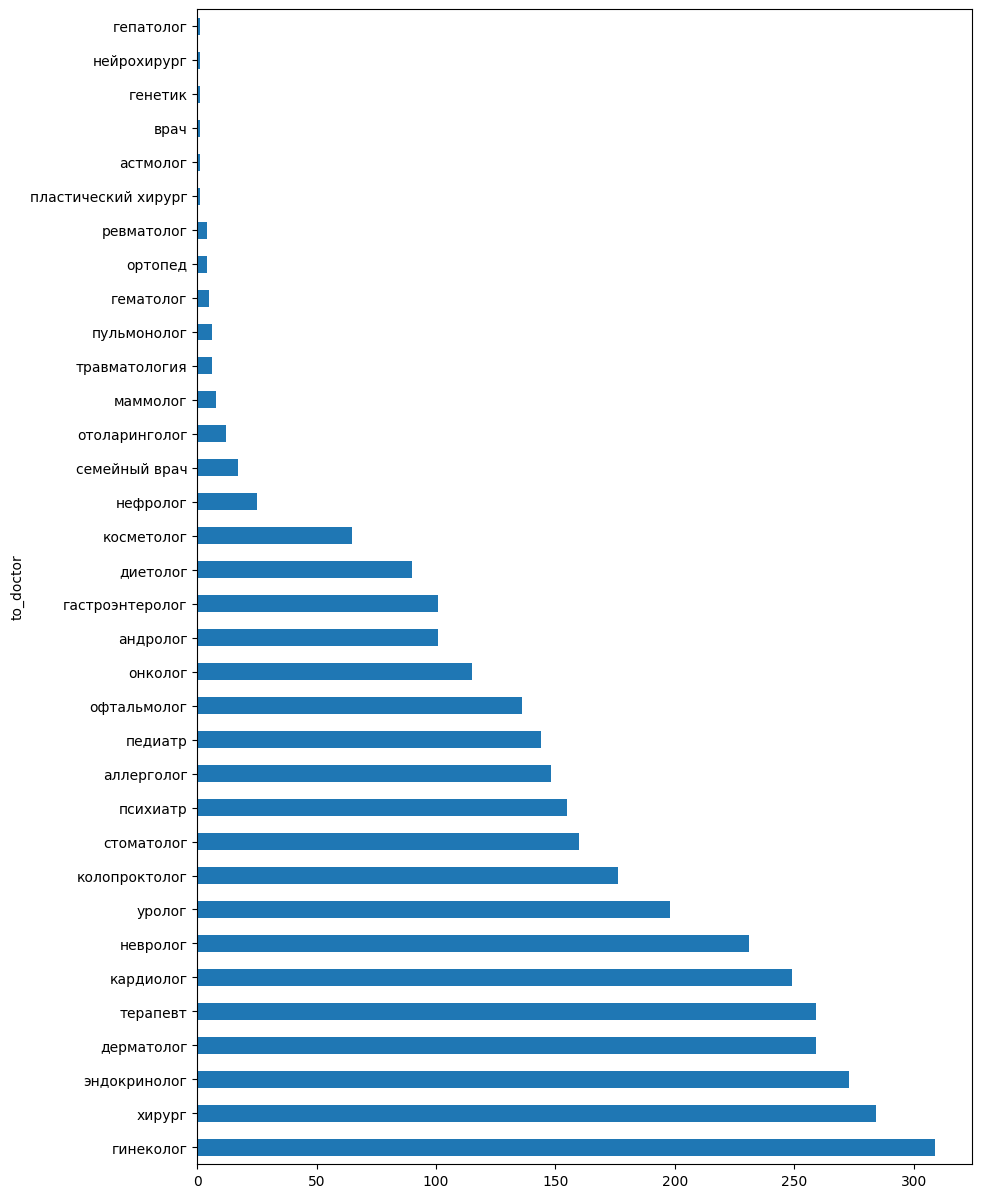

In [201]:
#Посмотрим на изменения в распределении названий назначенных врачей
plt.figure(figsize=(10, 15))
df['to_doctor'].value_counts().plot(kind='barh')
plt.xticks(fontsize=10)  # Уменьшаем размер шрифта по оси X
plt.yticks(fontsize=10)  # Уменьшаем размер шрифта по оси Y

In [202]:
#Обьединим ещё несколько специальностей
df['to_doctor'] = df['to_doctor'].apply(lambda x: 'уролог' if x == 'андролог' else x)
df['to_doctor'] = df['to_doctor'].apply(lambda x: 'терапевт' if x == 'семейный врач' else x)
df['to_doctor'] = df['to_doctor'].apply(lambda x: 'пульмонолог' if x == 'астмолог' else x)
df['to_doctor'] = df['to_doctor'].apply(lambda x: 'травмотолог' if x == 'ортопед' else x)
df['to_doctor'] = df['to_doctor'].apply(lambda x: 'узкий специалист' if x == 'гепатолог' or x == 'генетик' or x == 'пластический хирург' or x == 'нейрохирург' or x == 'врач'
                                        else x)




(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 [Text(0, 0, 'гинеколог'),
  Text(0, 1, 'уролог'),
  Text(0, 2, 'хирург'),
  Text(0, 3, 'терапевт'),
  Text(0, 4, 'эндокринолог'),
  Text(0, 5, 'дерматолог'),
  Text(0, 6, 'кардиолог'),
  Text(0, 7, 'невролог'),
  Text(0, 8, 'колопроктолог'),
  Text(0, 9, 'стоматолог'),
  Text(0, 10, 'психиатр'),
  Text(0, 11, 'аллерголог'),
  Text(0, 12, 'педиатр'),
  Text(0, 13, 'офтальмолог'),
  Text(0, 14, 'онколог'),
  Text(0, 15, 'гастроэнтеролог'),
  Text(0, 16, 'диетолог'),
  Text(0, 17, 'косметолог'),
  Text(0, 18, 'нефролог'),
  Text(0, 19, 'отоларинголог'),
  Text(0, 20, 'маммолог'),
  Text(0, 21, 'пульмонолог'),
  Text(0, 22, 'травматология'),
  Text(0, 23, 'гематолог'),
  Text(0, 24, 'узкий специалист'),
  Text(0, 25, 'ревматолог'),
  Text(0, 26, 'травмотолог')])

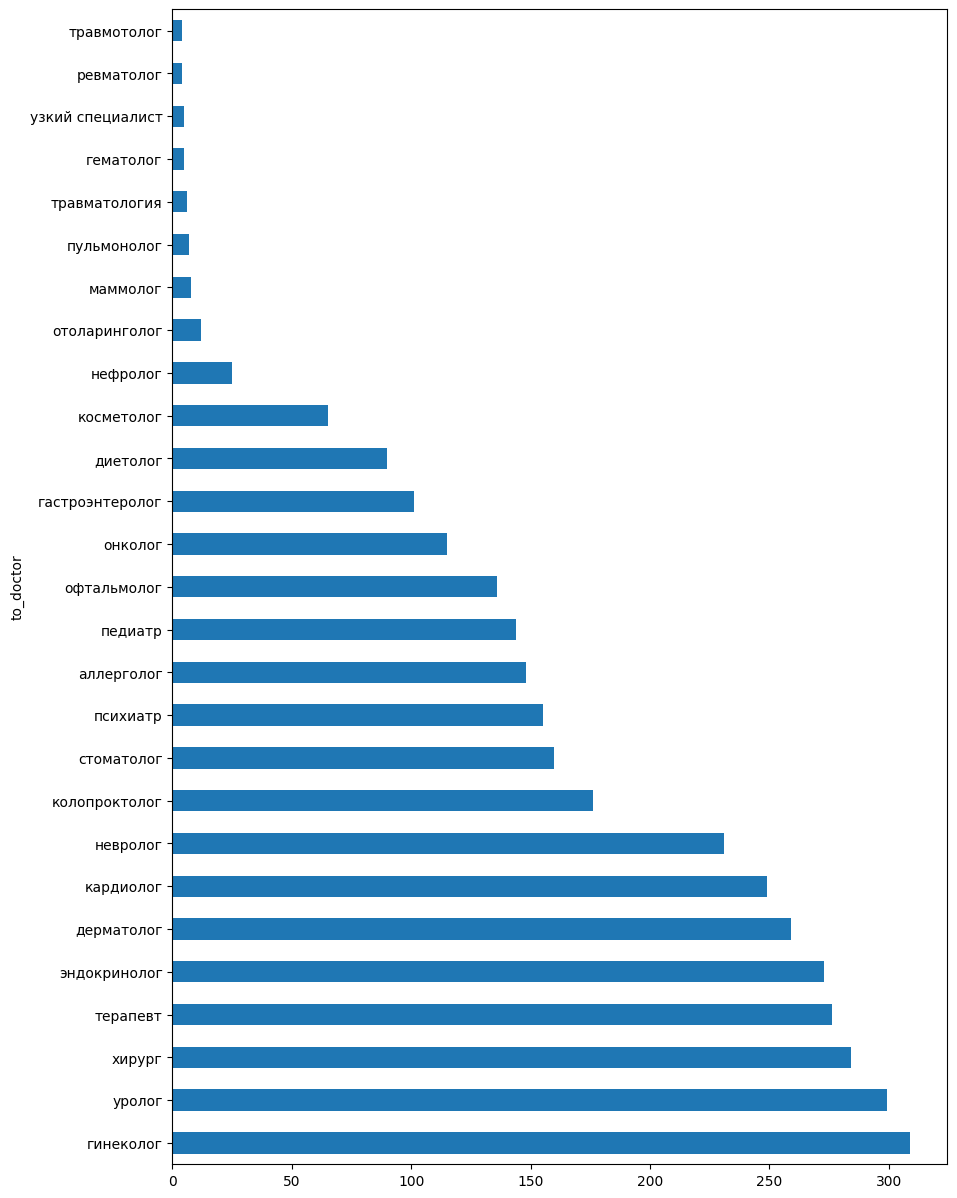

In [203]:
#Посмотрим на изменения в распределении названий назначенных врачей
plt.figure(figsize=(10, 15))
df['to_doctor'].value_counts().plot(kind='barh')
plt.xticks(fontsize=10)  # Уменьшаем размер шрифта по оси X
plt.yticks(fontsize=10)  # Уменьшаем размер шрифта по оси Y

In [204]:
#Теперь проводим токенизацию:
df['user_question_tokens'] = df['user_question_cleaned'].apply(word_tokenize)
df['assistant_answer_tokens'] = df['assistant_answer_cleaned'].apply(word_tokenize)

df['user_question_tokens']

,user_question_tokens
0,"[я, сдала, анализ, крови, на, сахар, и, показа..."
1,"[мой, ребенок, кашляет, уже, дня, отхаркиваетс..."
2,"[я, заметил, не, очень, приятного, вида, опухо..."
3,"[у, меня, повышенный, уровень, сахара, в, кров..."
4,"[у, меня, постоянно, болит, голова, я, уже, не..."
...,...
3541,"[вопрос, user, по, его, конкретной, медицинско..."
3542,"[у, меня, ушиб, локтя, очень, болит, и, опух, ..."
3543,"[у, меня, болит, живот, врач, предположил, что..."
3544,"[я, чувствую, постоянную, тревогу, и, усталост..."


Анализ данных

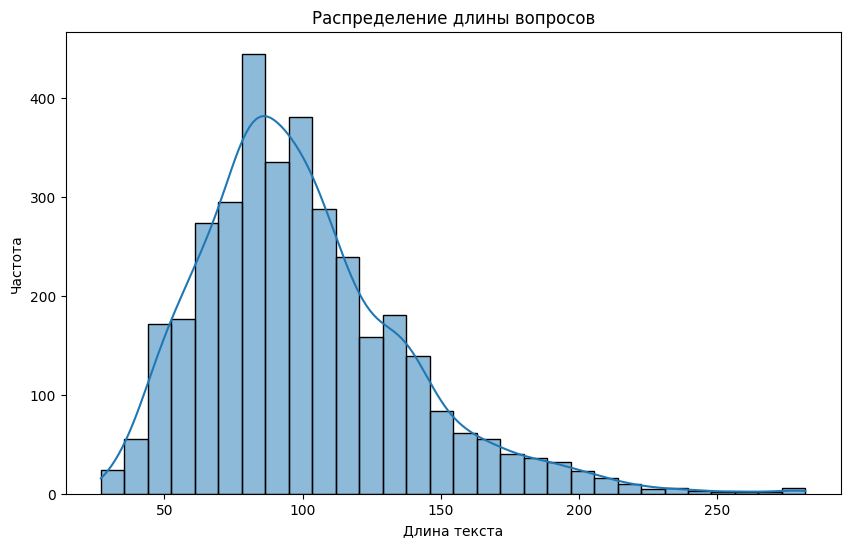

In [205]:
#Распределение длины текста user_question
df['question_length'] = df['user_question'].str.len()  # длина текста

plt.figure(figsize=(10, 6))
sns.histplot(df['question_length'], bins=30, kde=True)
plt.title('Распределение длины вопросов')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.show()

In [206]:
#Видим что чаще всего вопросы имеют длину 70-100 символов

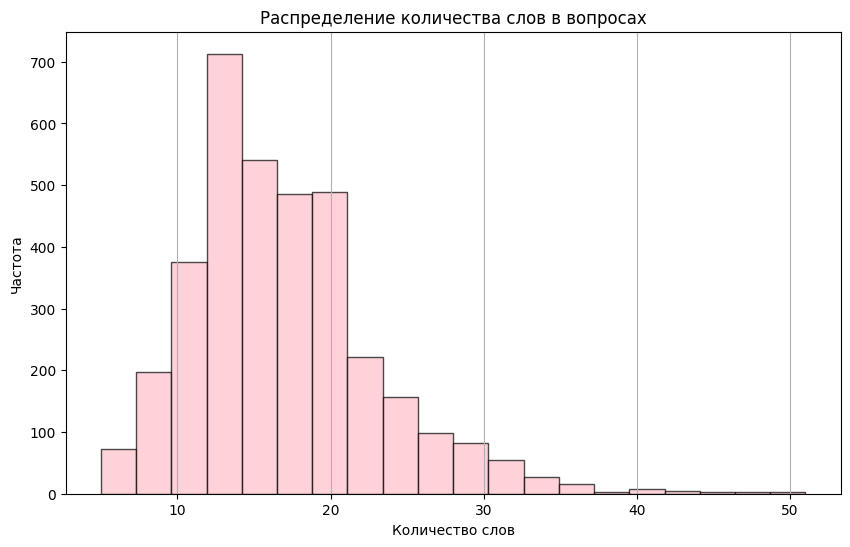

In [207]:
#График распределения количества слов в вопросе

df['word_count'] = df['user_question'].str.split().str.len()
plt.figure(figsize=(10, 6))
df['word_count'].hist(bins=20, alpha=0.7, color='pink', edgecolor='black')
plt.title('Распределение количества слов в вопросах')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.grid(axis='y')
plt.show()

#Подсчитайте самые частотные слова

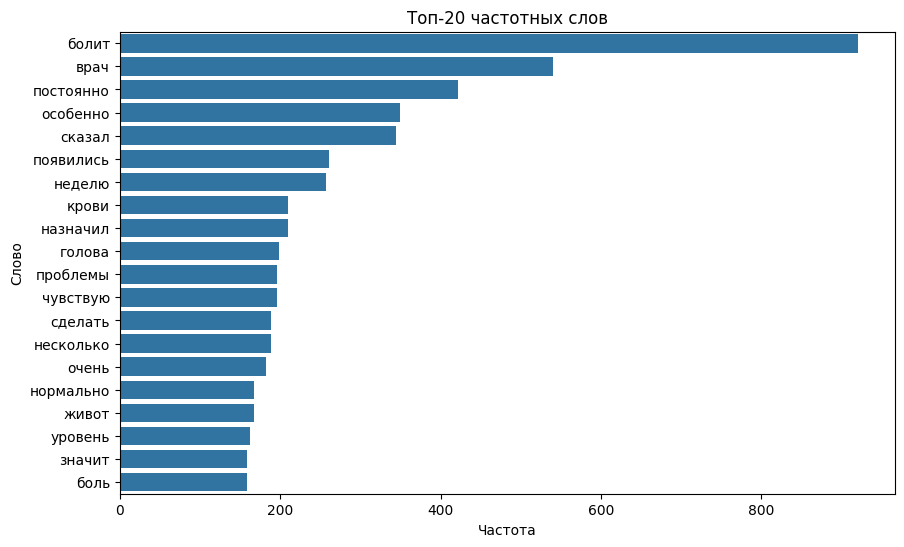

In [208]:
# Получение списка токензированных слов
all_words = ' '.join(df['user_question']).lower()
tokens = word_tokenize(all_words)

stopwords = set(nltk.corpus.stopwords.words('russian')) # Удаление стоп-слов

# Задаём кастомные стоп-слова
custom_stopwords = {"это", "могу", "часто", "нужно", "какие", "делать"}

# Объединяем стандартные и кастомные стоп-слова в один набор
all_stopwords = stopwords.union(custom_stopwords)
filtered_tokens = [word for word in tokens if word.isalpha() and word not in all_stopwords]

word_freq = Counter(filtered_tokens) # Подсчет частотных слов
common_words = word_freq.most_common(20)

# График частотных слов
words, counts = zip(*common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title('Топ-20 частотных слов')
plt.xlabel('Частота')
plt.ylabel('Слово')
plt.show()

Полсчёт самых частотных три- и биграмм

In [209]:
bigrams = Counter(ngrams(filtered_tokens, 2)).most_common(10)
trigrams = Counter(ngrams(filtered_tokens, 3)).most_common(10)

print("Топ-10 биграмм:")
for bigram, freq in bigrams:
    print(f"{' '.join(bigram)}: {freq}")
print("\nТоп-10 триграмм:")
for trigram, freq in trigrams:
    print(f"{' '.join(trigram)}: {freq}")

Топ-10 биграмм:
врач сказал: 280
врач назначил: 184
болит голова: 174
болит живот: 159
болит зуб: 152
несколько дней: 116
повышенный уровень: 84
учащенное сердцебиение: 83
постоянно болит: 80
появилась сыпь: 79

Топ-10 триграмм:
болит голова неделю: 63
сердцебиение особенно нервничаю: 55
учащенное сердцебиение особенно: 48
постоянно болит голова: 47
постоянно чешется кожа: 46
какому врачу обратиться: 45
болит анальное отверстие: 45
болит живот внизу: 44
врач сказал связано: 44
болит зуб несколько: 42


Облако слов

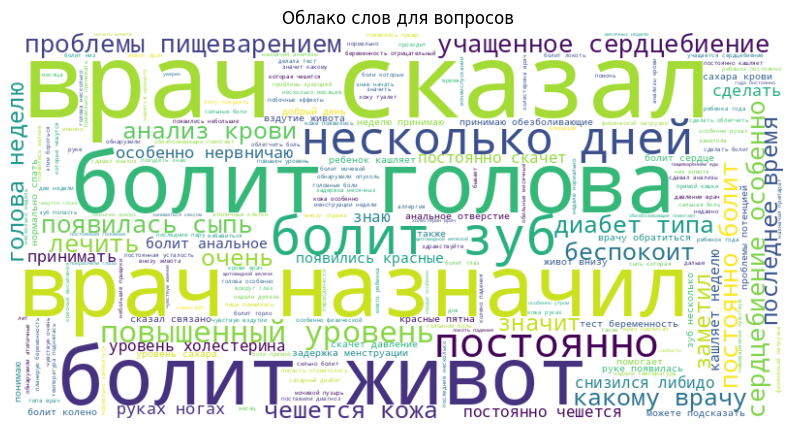

In [210]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_tokens))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для вопросов')
plt.show()


Предобработка данных

In [211]:
## Получение данных для предсказания

all_words = ' '.join(df['user_question']).lower()

# стоп-слова
stopwords = set(nltk.corpus.stopwords.words('russian'))
custom_stopwords = {"это", "могу", "часто", "нужно", "какие", "делать"}
# Объединение стандартных и кастомных стоп-слов
all_stopwords = stopwords.union(custom_stopwords)

# Получение токнов(с фильтрацией)
def preprocess_text(text, stopwords):
    tokens = word_tokenize(text.lower())  # Распознаем токены из текста
    return [word for word in tokens if word.isalpha() and word not in stopwords]

df['tokens'] = df['user_question'].apply(lambda x: preprocess_text(x, all_stopwords))

In [212]:
# Обучение Word2Vec на очищенных токенах
from gensim.models import Word2Vec
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)

In [213]:
# Функция для получения среднего эмбеддинга для текста
def get_avg_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)


In [214]:
# Подсчет эмбеддингов для каждого вопроса
df['embedding'] = df['tokens'].apply(lambda tokens: get_avg_embedding(tokens, w2v_model))

In [215]:
# Разделение на признаки и метки
X = np.vstack(df["embedding"].values)

Теперь попробуем представить классы специалистов в виде кодов на основе весa(weight) каждого класса

In [216]:
df['to_doctor'].value_counts()

,count
to_doctor,
гинеколог,309
уролог,299
хирург,284
терапевт,276
эндокринолог,273
дерматолог,259
кардиолог,249
невролог,231
колопроктолог,176


In [217]:
class_counts = {
    'гинеколог': 309, 'эндокринолог': 273, 'терапевт': 276,
    'хирург' : 284,
    'дерматолог': 259, 'кардиолог': 249, 'невролог': 231,
    'уролог': 299, 'колопроктолог': 176, 'стоматолог': 160,
    'психиатр': 155, 'аллерголог': 148, 'педиатр': 144,
    'офтальмолог': 136, 'онколог': 115,
    'гастроэнтеролог': 101, 'диетолог': 90, 'косметолог': 65,
    'нефролог': 25, 'отоларинголог': 12,
    'маммолог': 8, 'пульмонолог': 7, 'травматология': 4,
    'гематолог': 5, 'ревматолог': 4, 'узкий специалист': 5,
    'травмотолог': 4}

# Суммарное количество
total_samples = sum(class_counts.values())

# Рассчитываем веса
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# Для удобства
class_weights_df = pd.DataFrame(class_weights.items(), columns=['Class', 'Weight'])
print(class_weights_df)

               Class      Weight
0          гинеколог   11.469256
1       эндокринолог   12.981685
2           терапевт   12.840580
3             хирург   12.478873
4         дерматолог   13.683398
5          кардиолог   14.232932
6           невролог   15.341991
7             уролог   11.852843
8      колопроктолог   20.136364
9         стоматолог   22.150000
10          психиатр   22.864516
11        аллерголог   23.945946
12           педиатр   24.611111
13       офтальмолог   26.058824
14           онколог   30.817391
15   гастроэнтеролог   35.089109
16          диетолог   39.377778
17        косметолог   54.523077
18          нефролог  141.760000
19     отоларинголог  295.333333
20          маммолог  443.000000
21       пульмонолог  506.285714
22     травматология  886.000000
23         гематолог  708.800000
24        ревматолог  886.000000
25  узкий специалист  708.800000
26       травмотолог  886.000000


In [218]:
#Чем меньше встречается, тем больий вес имеет специальность(чтобы модель обратила больше внимания)
# Добавляем кодировки (коды профессиональных классов)
profession_to_code = {profession: idx for idx, profession in enumerate(class_weights.keys())}
df['weight_to_doctor'] = df['to_doctor'].map(class_weights)

In [219]:
# Теперь получим профессиональные коды

df['code'] = df['to_doctor'].map(profession_to_code)

In [220]:
y = df['code']

In [221]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [222]:
# Делим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Предобученная BERT модель с платформы HuggingFace

In [223]:
# Обучение модели случайного леса для дальнейшего сравнения с BERT
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = clf.predict(X_test)

# Оценка модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.70      0.67        61
           1       0.43      0.70      0.54        54
           2       0.29      0.30      0.30        43
           3       0.46      0.67      0.55        55
           4       0.68      0.83      0.75        59
           5       0.81      0.59      0.68        44
           6       0.49      0.60      0.54        47
           7       0.58      0.74      0.65        54
           8       0.80      0.67      0.73        30
           9       0.87      0.81      0.84        32
          10       0.85      0.46      0.60        37
          11       0.73      0.47      0.58        40
          12       0.88      0.85      0.86        26
          13       0.76      0.43      0.55        30
          14       0.62      0.58      0.60        26
          15       0.50      0.35      0.41        20
          16       0.44      0.19      0.27        21
    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [224]:
from transformers import AutoTokenizer, AutoModel
import torch
# Загрузка токенайзера и модели RuBERT
MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# Функция для получения эмбеддинга текста
def get_text_embedding(text, tokenizer, model, max_length=128):
    inputs = tokenizer(
        text, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt"
    )
    with torch.no_grad():
        outputs = model(**inputs)
        # Возьмем эмбеддинги CLS-токена (первая позиция [CLS])
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [225]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report, accuracy_score
# Препроцессинг: преобразование токенов в строки
df["text"] = df["tokens"].apply(lambda x: " ".join(x))  # Преобразуем токены в текст
labels = df["code"].values  # Целевые метки

# Разделяем данные на обучающую и тестовую выборки
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"].tolist(), labels, test_size=0.2, random_state=42
)

# Загрузка токенайзера и модели BERT
MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(set(labels)))

# Токенизация текстов
def preprocess_function(texts, labels):
    """Функция для токенизации данных"""
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Создаем датасеты в формате PyTorch
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = CustomDataset(train_encodings, train_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

# Определяем аргументы для обучения
training_args = TrainingArguments(
    output_dir="./results",          # Папка для результатов
    evaluation_strategy="epoch",    # Оценка на тестовых данных каждый эпоху
    learning_rate=2e-5,             # Скорость обучения
    per_device_train_batch_size=16, # Размер батча
    per_device_eval_batch_size=64,  # Размер батча для теста
    num_train_epochs=3,             # Количество эпох
    weight_decay=0.01,              # Регуляризация L2
    logging_dir="./logs",           # Папка для логов
    logging_steps=10,
    save_total_limit=2,
     report_to="none" # Максимальное количество сохраненных чекпоинтов
)

# Определяем метрику для оценки
def compute_metrics(eval_pred):
    """Функция для расчета метрик (accuracy)"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

# Используем Trainer API для обучения модели
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Обучение модели
trainer.train()

# Тестирование модели
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
print(classification_report(test_labels, preds))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-225-a4a19679e659>:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,1.555200,1.321927,0.757746
2,0.928500,0.810704,0.822535
3,0.756800,0.733003,0.838028


              precision    recall  f1-score   support

           0       0.96      0.90      0.93        61
           1       0.84      0.89      0.86        54
           2       0.40      0.53      0.46        43
           3       0.93      0.95      0.94        55
           4       0.75      0.88      0.81        59
           5       0.92      0.80      0.85        44
           6       0.82      0.96      0.88        47
           7       0.84      0.96      0.90        54
           8       0.90      0.93      0.92        30
           9       1.00      0.97      0.98        32
          10       0.94      0.92      0.93        37
          11       0.88      0.95      0.92        40
          12       0.89      0.96      0.93        26
          13       0.97      0.97      0.97        30
          14       0.80      0.92      0.86        26
          15       0.70      0.70      0.70        20
          16       1.00      0.29      0.44        21
          17       1.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [226]:
df["text"] = df["tokens"].apply(lambda x: " ".join(x))  # Преобразуем токены в текст
labels = df["code"].values  # Целевые метки
df["text"]

,text
0,сдала анализ крови сахар показатели повышены в...
1,ребенок кашляет дня отхаркивается трудом сдела...
2,заметил очень приятного вида опухоль возле ана...
3,повышенный уровень сахара крови врач сказал са...
4,постоянно болит голова несколько дней принимаю...
...,...
3541,вопрос user конкретной медицинской проблеме
3542,ушиб локтя очень болит опух
3543,болит живот врач предположил аппендицит назнач...
3544,чувствую постоянную тревогу усталость происходит
